## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

matplotlib.style.use('ggplot')

np.random.seed(1234)

In [62]:
p_value_ = 1
ndims_ = 1
nparams_ = 2
N_ = 500000
T_ = 50

r_value = 3.8
r_bkg = 3.7
#r_value = 44.7
#r_bkg = 70.
sigma_2_value = 0.3
sigma_2_bkg = 0.3
phi_value = 10.
phi_bkg = 9.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")
shared_params = [shared_r, shared_phi]

bounds = [(3.7, 3.95), (9., 11.)]
#bounds = [(35.,85.), (3.,6.)]
n_points = 5

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        #r_e = r
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [63]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(sigma_2_value,name="sigma_2_1"),
            phi = theano.shared(phi_bkg, name="phi_1")
            )
rng = np.random.RandomState(1234)

n_true = 1000
#X_true = p0.rvs(1000,random_state=rng)
X_true = np.array([p0.rvs(T_, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [ ]:
import warnigs
warnings.filterwarnings('ignore')

In [64]:
def covariances(X, k, u):
    if len(X.shape) > 1:
        N = X.shape[1]
    else:
        N = X.shape[0]
    return (1./(N-1))* (np.array([(X[:,i+k] - u)*(X[:,i] - u) 
                                      for i in range(N-k)])).sum(axis=0)

# Need to code it for more lags
def differences(X):
    if len(X.shape) > 1:
        X_ = np.zeros((X.shape[0], X.shape[1]-1))
        for k in range(len(X)):
            X_[k] = X[k][1:] - X[k][:-1]
        return X_
    return X[1:] - X[:-1]

def normalize(X):
    if len(X.shape) > 1:
        return X - X.mean(axis=1, keepdims=True)
    return X - X.mean()

# TODO: In the paper Wood doesn't use an itercept term!! (hera I'm using)
def poly_regression(X, y, deg=3):
    reg = np.polyfit(X, y, deg=deg)
    return reg

def poly_autoregression(X_r, X_x, deg=2):
    betas_x = []
    for k in range(X_r.shape[0]):
        keep = ~np.logical_or(np.isnan(X_r[k,:]), np.isnan(X_x[k,:]))
        if np.any(keep):
            X_r_, X_x_ = X_r[k,keep], X_x[k,keep]
            try:
                beta = poly_regression(X_x_, X_r_, deg=deg)
            except ValueError:
                #print('Errors on {0}'.format(k))
                beta = np.array([0.,0.,0.])
        else:
            beta = np.array([0.,0.,0.])
        betas_x.append(beta)
    return np.array(betas_x)

def cubic_regression(y, X, deg=3):
    betas_x = []
    for k in range(X.shape[0]):
        beta = poly_regression(y, X[k], deg=deg)
        betas_x.append(beta)
    return np.array(betas_x)
    
def compute_S(X_true, Xs):
    real = 0
    autoreg_deg = 2
    cubic_deg = 3
    X_true = X_true.reshape(X_true.shape[0], X_true.shape[1])
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1])
    # Cubic regression on differences
    # Take any X_true as the true value
    X_true_diff = normalize(differences(X_true[real]))
    Xs_diff = normalize(differences(Xs))
    for k in range(Xs_diff.shape[0]):
        Xs_diff[k].sort()
    X_true_diff.sort()
    diff_reg_x = cubic_regression(X_true_diff, Xs_diff, cubic_deg)
    # Assuming regression equal y    
    Xs_true_diff = normalize(differences(X_true))
    for k in range(Xs_diff.shape[0]):
        Xs_diff[k].sort()
    diff_reg_y = cubic_regression(X_true_diff, Xs_true_diff, cubic_deg)
    # Polynomial Autoregression
    Xs_n = normalize(Xs)
    X_r =  np.array([xs[1:]**0.3 for xs in Xs_n])
    X_x =  np.array([xs[:-1]**0.3 for xs in Xs_n])
    y_n = normalize(X_true)
    y_r =  np.array([xs[1:]**0.3 for xs in y_n])
    y_x =  np.array([xs[:-1]**0.3 for xs in y_n])

    betas_x = poly_autoregression(X_r, X_x, autoreg_deg)
    betas_y = poly_autoregression(y_r, y_x)
    #betas_y = np.zeros((y_r.shape[0], autoreg_deg + 1))
    #betas_y[:,1] = 1.
    # Autocovariances to lag 5
    u_x = Xs.mean(axis=1)
    covs_x =np.array([covariances(Xs, k, u_x) for k in range(6)])
    u_y = X_true.mean(axis=1)
    covs_y = np.array([covariances(X_true, k, u_y) for k in range(6)])
    # Number of zeros observed
    zeros_x = (Xs == 0.).sum(axis=1)
    zeros_y = (X_true == 0.).sum(axis=1)
    S_x = [np.hstack((diff_reg_x[k], betas_x[k], covs_x[:,k], u_x[k], zeros_x[k]))
           for k in range(Xs.shape[0])]
    S_y = [np.hstack((diff_reg_y[k], betas_y[k], covs_y[:,k], u_y[k], zeros_y[k])) 
           for k in range(X_true.shape[0])]
    return (S_x, S_y)

In [37]:
compute_S(X_true, X1_) 

> <ipython-input-36-f3d21abd5382>(84)compute_S()
-> u_x = Xs.mean(axis=1)
(Pdb) betas_y
array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])
(Pdb) betas_y[0:100
*** SyntaxError: unexpected EOF while parsing (<stdin>, line 1)
(Pdb) betas_y[0:100]
array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-3.07784153,  0.43056932,  4.71398827],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0. 

BdbQuit: 

In [66]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=n_points)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=n_points))]
combinations = list(product(*bounds_values))

In [67]:
print(len(combinations))

25


In [68]:
Xs = []

for k,value in enumerate(combinations):
    for i,v in enumerate(value):
        shared_params[i].set_value(v)
    print(k),
    X0_ = np.array([p0.rvs(T_, random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])
    Xs.append(X0_)

X1_ = np.array([p1.rvs(T_, random_state=np.random.randint(0,5000)) 
               for i in range(N_//2)])


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [69]:
Xs = np.array(Xs)
print(Xs.shape)
print(X1_.shape)

(25, 250000, 50, 1)
(250000, 50, 1)


In [70]:
Xs_s = []
for k in range(Xs.shape[0]):
    print(k),
    s, y_s = compute_S(X_true, Xs[k])
    Xs_s.append(s)
Xs_s = np.array(Xs_s)
X_true_s = np.array(y_s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [71]:
X1_s,_ = compute_S(X_true, X1_) 
X1_s = np.array(X1_s)

In [72]:
print(Xs_s.shape)
print(X1_s.shape)
print(X_true_s.shape)

(25, 250000, 15)
(250000, 15)
(1000, 15)


In [8]:
Xs_s, X1_s, X_true_s = pickle.load(open('data/ricker_transformed.dat', 'r'))

In [52]:
#X_min = Xs.min(axis=3)[:1]
#X_true_min = X_true.min(axis=0)
#Xs_min = np.vstack((X_min, X_true_min)).min(axis=0)

In [53]:
#X_c = np.log(Xs + 1.)
#X_true_c = np.log(X_true + 1.)
#X1_c = np.log(X1_ + 1.)

In [54]:
#Xs = X_c
#X_true = X_true_c
#X1_ = X1_c

In [53]:
X = Xs[0][0]

0.0 6.04263283368
0.0 4.86753445046


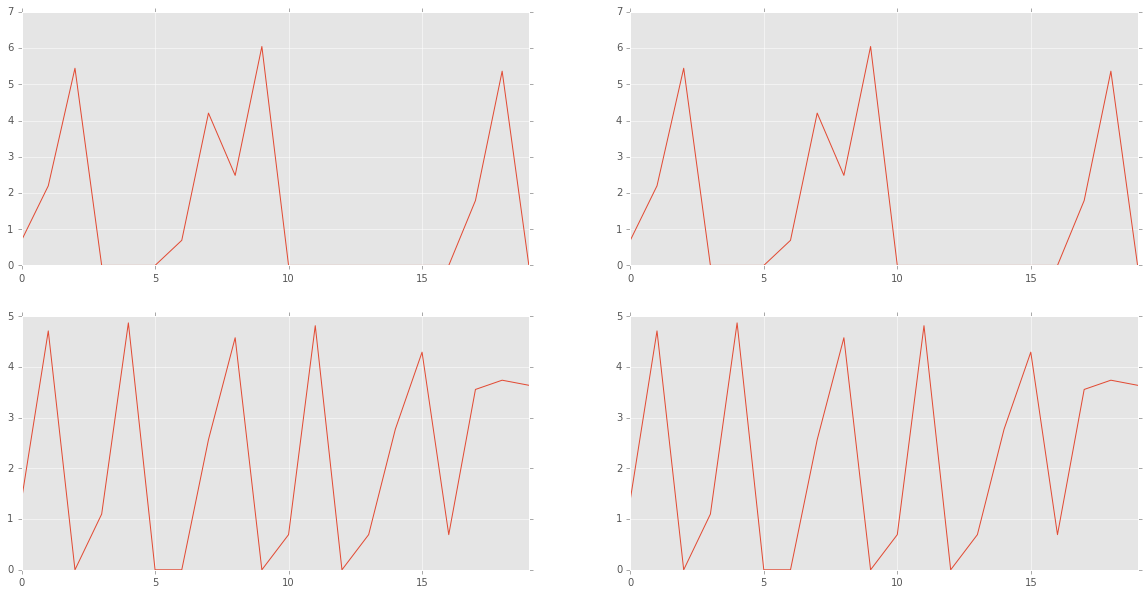

In [56]:
serie1 = X1_[0][:,0]
serie2 = Xs[0][0][:,0]
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [74]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [75]:

def make_model_join():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=(T_, ndims_)))
    model.add(Dense(5, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

In [73]:
pickle.dump((Xs_s, X1_s, X_true_s), open('data/ricker_transformed.dat', 'w'))

In [88]:
def make_ratio(num):
    X_num = Xs_s[num]
    X_den = X1_s
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    #clf = KerasClassifier(make_model_join, nb_epoch=20, verbose=0)

    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)
    #clf.fit(X, y)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)
    
    return ratio

In [89]:
import multiprocessing
#multiprocessing.set_start_method('forkserver')
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

OSError: [Errno 12] Cannot allocate memory

In [ ]:
n_sample_points = len(combinations)
points = list(range(n_sample_points))
clf_ratios = []
for i, k in enumerate([points[n:n + num_cores] for n in range(0, n_sample_points, num_cores)]):
    print('Iteration {0}'.format(i))
    clf_ratios += pool.map(make_ratio, k)

In [ ]:
llr = []
zeros = []
distances = []
#shared_r.set_value(r_value)
#shared_phi.set_value(phi_value)
#n_true = 10
#X_true = np.array([p0.rvs(T_, random_state=np.random.randint(0,5000))
#                   for i in range(n_true)])
#X_true = np.log(X_true + 1.)

for i, theta in enumerate(combinations):
    print(i, theta)
    ratio = clf_ratios[i]
    ratios = ratio.predict(X_true_s, log=True)
    print ratios[np.isinf(ratios)].shape
    zeros.append(ratios[np.isinf(ratios)].shape[0])
    ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
    nllr = -np.mean(ratios) 
    llr.append(nllr)
    #nllr = ratio.nnlr(X_observed)
    #llr.append(ratio.nllr(X_true))
    print(llr[-1])

In [80]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.
llr_original = llr.copy()
llr *= 19.2 / len(X_true)

([3.8873747494989983], [9.0])


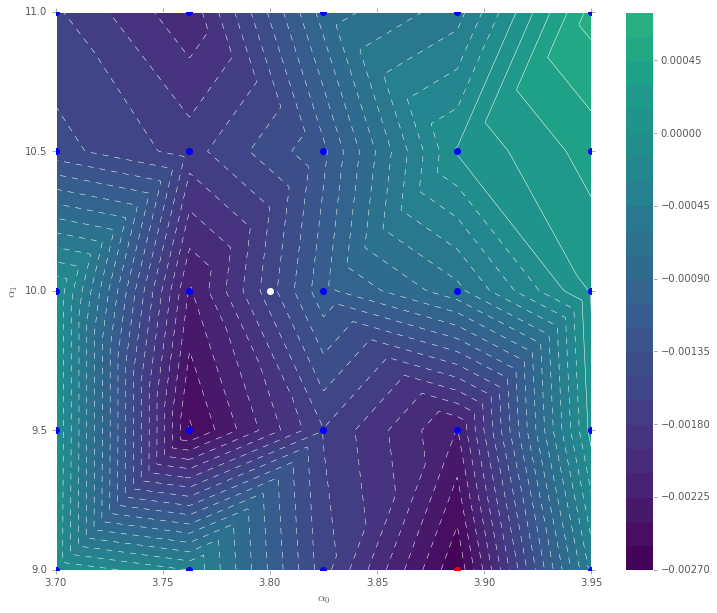

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
thetas = np.array([v for v in product(As, Bs)])
zi = griddata(thetas[:, 0], thetas[:, 1], llr, xi, yi, interp='linear')
mle = np.unravel_index(zi.argmin(),zi.shape)
zi = zi.transpose()
print([xi[mle[0]]], [yi[mle[1]]])

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                 vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.colorbar()  
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([r_value],[phi_value], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[0]]], [yi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
plt.show()

In [55]:
llr, zeros = pickle.load(open('data/clf_results.dat', 'r'))

In [45]:
print(np.array(llr).reshape(5,5))

[[-0.         -0.         -3.29067998 -3.48963595 -2.45796554]
 [-0.23081427 -0.         -3.7402703  -3.20513538 -3.2118657 ]
 [-0.56349927 -3.00130844 -3.37923945 -2.803628   -2.88197846]
 [-1.54619293 -2.57918294 -2.85118868 -1.78880409  0.17728886]
 [-1.60295942 -2.87503238 -2.63770129 -1.10468948  3.20674092]]


(1, 0)


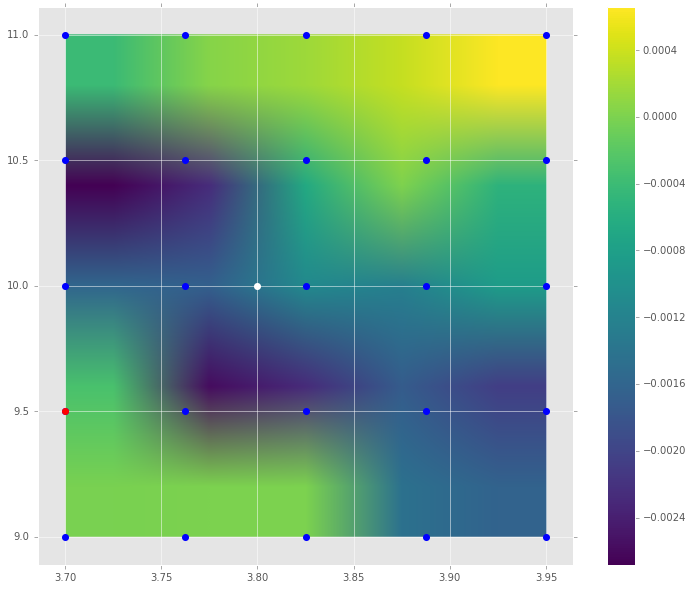

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from itertools import product
plt.rcParams["figure.figsize"] = (12, 10)
thetas = np.array([v for v in product(As, Bs)])

llr_ = np.array(llr).reshape(n_points, n_points)
llr_ = np.flipud(llr_.transpose())
mle = np.unravel_index(llr_.argmin(),llr_.shape)
plt.imshow(llr_, aspect='auto', cmap='viridis',
           extent = (bounds[0][0], bounds[0][1],bounds[1][0], bounds[1][1]))
print(mle)
plt.colorbar()  
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([As[mle[1]]], [Bs[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([r_value],[phi_value], marker='o', c='w', s=50, lw=0, zorder=10)

plt.show()

(9.0, 11.0)

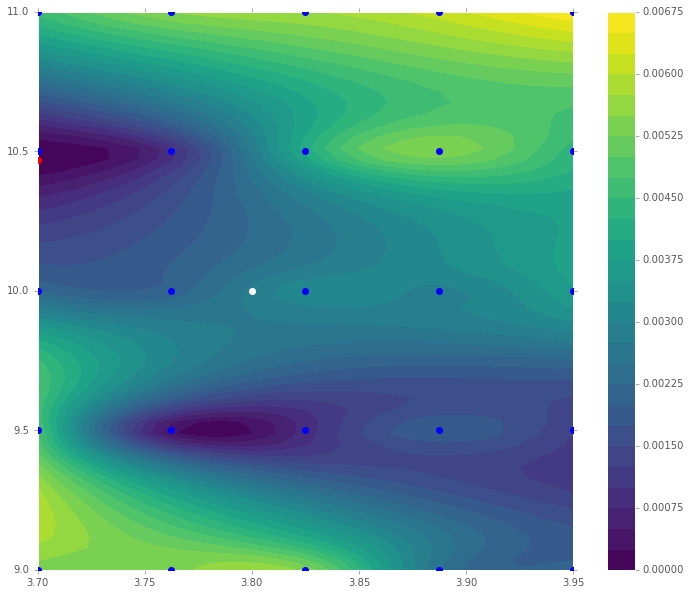

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
#gp.fit(np.delete(theta[:29, 1:],8,0), np.delete(llr,8))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
zi = zi

#cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([r_value],[phi_value], marker='o', c='w', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])

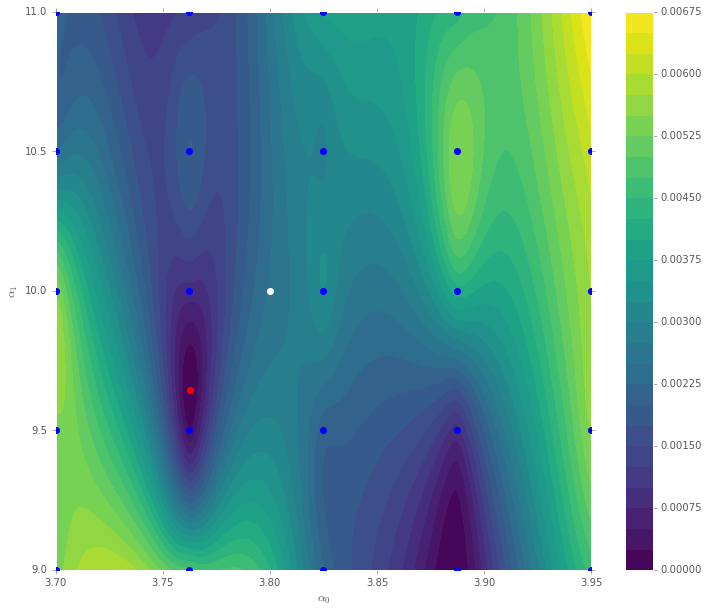

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
#gp.fit(np.delete(theta[:29, 1:],8,0), np.delete(llr,8))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
zi = zi.transpose()

#cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[0]]], [yi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([r_value],[phi_value], marker='o', c='w', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
plt.show()
plt.savefig('ricker_2d_approx.pdf')

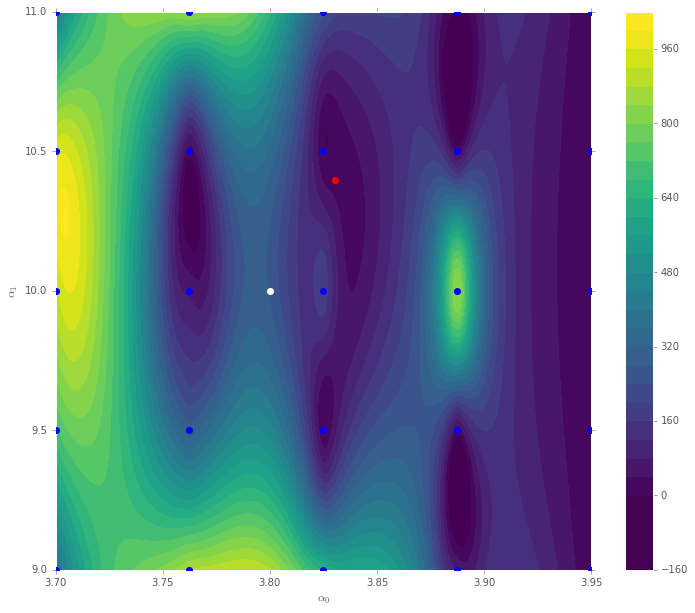

In [336]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=1.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
#gp.fit(np.delete(theta[:29, 1:],8,0), np.delete(llr,8))
gp.fit(thetas, zeros)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)
zi = zi.transpose()
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([r_value],[phi_value], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[0]]], [yi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)

#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
plt.show()

In [124]:
shared_alpha_0.set_value(alpha_value_0)
shared_alpha_1.set_value(alpha_value_1)
exact_contours = np.zeros(len(AABB))
combinations = product(As, Bs)
i = 0
for a in As:    
    for b in Bs:
        shared_alpha_0.set_value(a)
        shared_alpha_1.set_value(b)
        exact_contours[i] = np.mean([p0.nll(X_true[k]) for k in range(100)])
        i += 1
#exact_contours = 2. * (exact_contours - exact_contours.min()) * len(X_true)

In [125]:
exact_contours *= 19.2 / len(X_true)

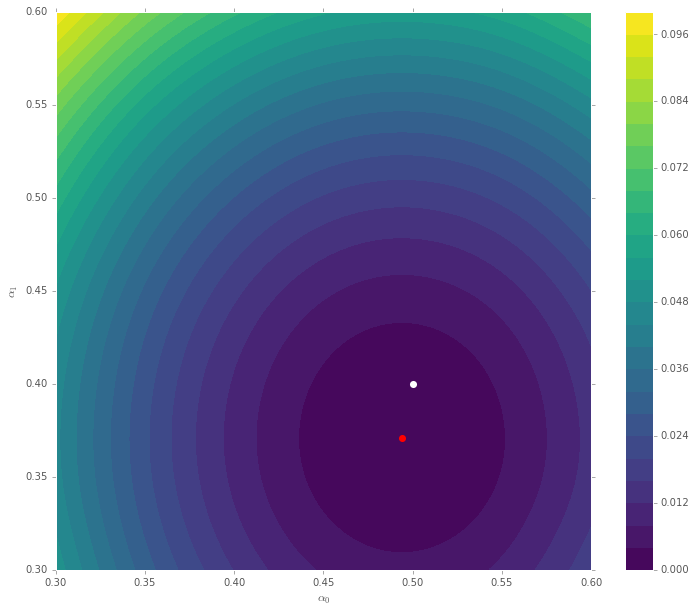

In [126]:
thetas = np.array([c for c in product(As, Bs)])
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
#gp.fit(np.delete(theta[:29, 1:],8,0), np.delete(llr,8))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

#cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

plt.colorbar()
#plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
plt.show()
plt.savefig('ar_2d_true.pdf')

In [219]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf_join, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x119c29d0>,
            bins=30, cv='prefit', method='histogram'),
        random_state=0)

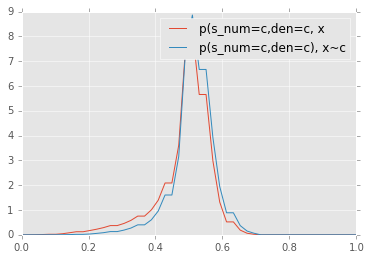

In [220]:
reals2 = np.linspace(0, 1)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [224]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 500
T_ = 500
def objective(theta, X_true = X_true, random_state=0):    
    print(theta)
    shared_alpha_0.set_value(theta[0])
    shared_alpha_1.set_value(theta[1])
    theta_array = np.empty((n_samples,len(theta)))
    def transform(x): return np.log(x + 1. - Xs_min)
    for i,v in enumerate(theta):
        theta_array[:,i].fill(v)
    serie1 = np.array([np.hstack((transform(p0.rvs(n_samples, 
                                                    random_state=np.random.randint(0,5000))),theta_array)) 
                   for i in range(T_//2)])
    for i in range(T_//2):
        if i == 0:
            X0 =  serie1[i]
        else:
            X0 = np.vstack((X0, serie1[i]))

    for i,v in enumerate(theta):
        theta_array[:,i].fill(v)
    serie2 = np.array([np.hstack((transform(p1.rvs(n_samples, 
                                                    random_state=np.random.randint(0,5000))),theta_array)) 
                   for i in range(T_//2)])
    for i in range(T_//2):
        if i == 0:
            X1 =  serie2[i]
        else:
            X1 = np.vstack((X1, serie2[i])) 

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]+X1_serie.shape[1],dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1

    # Fit ratio
    ratio_join = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_join, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    ratio_join.fit(X_serie, y_serie)
    
    # Fit ratio
    ratio_single = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_single, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    X_single = X_serie[:,0,:]
    y_single = y_serie[:]
    
    ratio_single.fit(X_single, y_single)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+nparams_))
    X_true_[:,:-nparams_] = X_true
    X_true_[:,-nparams_:] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r_join = ratio_join.predict(X_true_serie, log=True)
    r_single = -ratio_single.predict(X_true_serie[:,0,:], log=True)
    
    r_full = r_join[1:] + r_single[:-1]
    #r_full = r_join
    
    print r_full[np.isinf(r_full)].shape
    r_full = r_full[np.logical_and(np.isfinite(r_full),~np.isnan(r_full))]
    if r_full.size > 0:
        value = -np.mean(r_full)  # optimization is more stable using mean this will need to be rescaled by len(X_true)
    else:
        value = 0.
    print(value)
    #return r_full, serie1, serie2, ratio_join
    return value

In [155]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 250000
def objective(theta, X_true = X_true, random_state=0):    
    print(theta)
    shared_alpha_0.set_value(theta[0])
    shared_alpha_1.set_value(theta[1])
    serie1 = p0.rvs(n_samples)
    serie1 = np.log(serie1 + 1. - Xs_min)
    serie1[np.isnan(serie1)] = 0.
    serie1[np.isinf(serie1)] = 0.
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+nparams_))
    X0[:,:-nparams_] = serie1
    X0[:,-nparams_:] = theta    
    # Fit ratio
    ratio_join = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_join, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))

    #serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
    serie2 = p1.rvs(n_samples,random_state=random_state)
    serie2 = np.log(serie2 + 1. - Xs_min)
    serie2[np.isnan(serie2)] = 0.
    serie2[np.isinf(serie2)] = 0.

    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+nparams_))
    X1[:,:-nparams_] = serie2
    X1[:,-nparams_:] = theta
    pdb.set_trace()
    
    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]+X1_serie.shape[1],dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio_join.fit(X_serie, y_serie)
    
    # Fit ratio
    ratio_single = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_single, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    X_single = X_serie[:,0,:]
    y_single = y_serie[:]
    
    ratio_single.fit(X_single, y_single)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+nparams_))
    X_true_[:,:-nparams_] = X_true
    X_true_[:,-nparams_:] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r_join = ratio_join.predict(X_true_serie, log=True)
    r_single = -ratio_single.predict(X_true_serie[:,0,:], log=True)
    
    #r_full = r_join[1:] + r_single[:-1]
    r_full = r_join
    
    print r_full[np.isinf(r_full)].shape
    #r_full = r_full[np.logical_and(np.isfinite(r_full),~np.isnan(r_full))]
    #if r_full.size > 0:
    #    value = -np.mean(r_full)  # optimization is more stable using mean this will need to be rescaled by len(X_true)
    #else:
    #    value = 0.
    #print(value)
    return r_full, serie1, serie2, ratio_join
    return value

In [147]:
ratio_join.classifier_.predict_proba(X_true_serie[3].reshape(1,2,4))

array([[ 1.,  0.]])

In [64]:
ratio_join.predict(X_true_serie[11].reshape(1,2,4))

array([ inf])

In [151]:
print(X_true.shape)

(15000, 2)


In [225]:
n_points = 8

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))
shared_alpha_0.set_value(alpha_value_0)
shared_alpha_1.set_value(alpha_value_1)

approx_contours = np.zeros(len(AABB))
zeros = np.zeros(len(AABB))
#X_true = p0.rvs(20000, random_state=np.random.randint(0,5000))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i] = objective([a, b],X_true=X_true) 
        i += 1
        
print(approx_contours.min())
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

SyntaxError: invalid syntax (<ipython-input-225-c81fe3de9995>, line 15)

(0.47142857142857142, 0.38571428571428568) 0.0

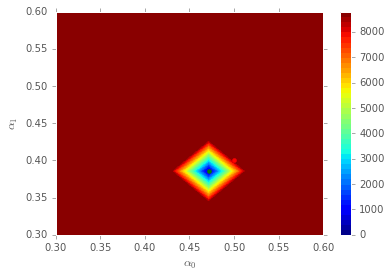

In [223]:
from scipy.stats import chi2
import pdb

min_value = np.unravel_index(approx_contours.argmin(),
            (8,8))
min_position = (As[min_value[0]],Bs[min_value[1]])
print '{0} {1}'.format(min_position, approx_contours.min()),
#plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
#            levels=[chi2.ppf(0.683, df=2), 
#                    chi2.ppf(0.9545, df=2),
#                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50)
plt.colorbar()

plt.plot([alpha_value_0], [alpha_value_1], "r.", markersize=8)
plt.plot([min_position[0]], [min_position[1]], "g.", markersize=8)


plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")

#plt.savefig("fig4c.pdf")
plt.show()

In [104]:
from GPyOpt.methods import BayesianOptimization
bounds = [(0.1,0.5)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.22384972]
(1,)
-0.00216551454125
[ 0.23066371]
(2,)
-0.000441152391242
[ 0.10198037]
(1,)
0.0471657688529
[ 0.49606812]
(9,)
-0.0453178636723
[ 0.45284154]
(2,)
-0.0453358845761
[ 0.46182173]
(2,)
-0.0424479348349
[ 0.5]
(5,)
-0.0458649533748
[ 0.5]
(2,)
-0.0426062066234
*Optimization completed:
   -Method converged.


0

In [ ]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

In [ ]:
solver.plot_acquisition()

In [ ]:
solver.plot_convergence()

In [ ]:
from scipy.optimize import minimize
shared_alpha.set_value(alpha_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0.4])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

In [ ]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

In [ ]:
#bounds = [(42.,46.)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
#ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
#                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=0.3**2,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model